In [1]:
# Step 1: Load and Extract AE Data

import scipy.io
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load the .mat file
mat_path = r'E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\mat files data\AE_ALL.mat'
mat_file = h5py.File(mat_path, 'r')

# List all top-level keys
print("Top-level keys:", list(mat_file.keys()))

# Access AE_ALL group
ae_all = mat_file['AE_ALL']
print("Class keys inside AE_ALL:", list(ae_all.keys()))

# Define target class names
target_classes = ['BF', 'GF', 'TF', 'NI']

# Extract each class
ae_data = {}
for cls in target_classes:
    class_ref = ae_all[cls][()]  # (1, 4) references
    signals = []
    for i in range(4):
        signal_ref = class_ref[0][i]  # h5py reference
        signal = np.array(mat_file[signal_ref])  # shape: (samples, segments)
        signals.append(signal)
    ae_data[cls] = signals
    print(f"{cls} loaded. Channels: {len(signals)}, Shape[0]: {signals[0].shape}")

mat_file.close()


Top-level keys: ['#refs#', 'AE_ALL']
Class keys inside AE_ALL: ['BF', 'BFI', 'GF', 'GFI', 'N', 'NI', 'TF']
BF loaded. Channels: 4, Shape[0]: (1000000, 40)
GF loaded. Channels: 4, Shape[0]: (1000000, 40)
TF loaded. Channels: 4, Shape[0]: (1000000, 40)
NI loaded. Channels: 4, Shape[0]: (1000000, 40)


In [11]:
import h5py
import numpy as np

# File path
mat_path = r'E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\mat files data\AE_ALL.mat'
mat_file = h5py.File(mat_path, 'r')

# Load AE_ALL group
ae_all = mat_file['AE_ALL']

# New Class Mapping
class_map = {
    'BF': 'BF',
    'GF': 'GF',
    'TF': 'TF',   # Replacing TF with GFI
    'N': 'NI'      # Replacing N with NI
}

# Load channel 1 data (index 0) for 4 classes
ae_data = {}
for new_cls, original_cls in class_map.items():
    class_ref = ae_all[original_cls][()]
    chan1_ref = class_ref[0][0]  # Channel 1
    chan1_data = np.array(mat_file[chan1_ref])  # shape: (1,000,000, 40)
    ae_data[new_cls] = chan1_data
    print(f"{new_cls}: Loaded shape {chan1_data.shape}")

mat_file.close()


BF: Loaded shape (1000000, 40)
GF: Loaded shape (1000000, 40)
TF: Loaded shape (1000000, 40)
N: Loaded shape (1000000, 40)


In [12]:
import numpy as np
import pywt
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# --- Wavelet Denoising ---
def wavelet_denoise(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs_thresh = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs]
    return pywt.waverec(coeffs_thresh, wavelet)

# --- Burst Activity Score (Envelope-based + Hilbert transform) ---
def burst_activity_score(signal):
    analytic = hilbert(signal)
    envelope = np.abs(analytic)
    burst_energy = np.sum(envelope**2)
    num_peaks = np.sum((envelope[1:-1] > envelope[:-2]) & (envelope[1:-1] > envelope[2:]))
    spectral_energy = np.sum(np.abs(np.fft.rfft(signal))**2)
    score = (burst_energy * num_peaks) / (spectral_energy + 1e-6)
    return score

# --- Initialize ---
denoised_signals = {}
burst_scores = {}

# --- Loop over each class ---
for cls in ae_data:
    class_data = ae_data[cls]
    denoised_signals[cls] = []
    burst_scores[cls] = []

    print(f"\nProcessing class: {cls}")
    for i in range(class_data.shape[1]):  # 40 samples per class
        signal = class_data[:, i]
        denoised = wavelet_denoise(signal)
        score = burst_activity_score(denoised)

        denoised_signals[cls].append(denoised)
        burst_scores[cls].append(score)

    print(f"{cls}: Avg Burst Score = {np.mean(burst_scores[cls]):.2f}")



Processing class: BF
BF: Avg Burst Score = 0.14

Processing class: GF
GF: Avg Burst Score = 0.15

Processing class: TF
TF: Avg Burst Score = 0.14

Processing class: N
N: Avg Burst Score = 0.11


In [13]:
import pandas as pd
from scipy.stats import kurtosis, skew
from scipy.signal import stft
from sklearn.preprocessing import StandardScaler

# --- Feature functions ---
def extract_features(signal, burst_score):
    features = {}

    # Statistical
    features['mean'] = np.mean(signal)
    features['std'] = np.std(signal)
    features['skewness'] = skew(signal)
    features['kurtosis'] = kurtosis(signal)

    # Spectral (STFT)
    f, t, Zxx = stft(signal, fs=1e6, nperseg=256)
    magnitude = np.abs(Zxx)
    psd = magnitude ** 2
    psd_sum = np.sum(psd, axis=0) + 1e-10

    # Spectral Centroid
    features['spectral_centroid'] = np.sum(f[:, None] * psd, axis=0).mean() / psd_sum.mean()

    # Spectral Bandwidth
    centroid = features['spectral_centroid']
    features['spectral_bandwidth'] = np.sum(((f[:, None] - centroid) ** 2) * psd, axis=0).mean() / psd_sum.mean()

    # Spectral Flatness
    features['spectral_flatness'] = np.exp(np.mean(np.log(psd + 1e-10))) / (np.mean(psd) + 1e-10)

    # Time-Frequency Domain
    features['tfd_energy'] = np.sum(psd)
    features['tfd_dominant_freq'] = f[np.argmax(np.mean(psd, axis=1))]

    # Burst domain
    features['burst_score'] = burst_score

    return features

# --- Extract for all samples ---
feature_rows = []
labels = []

for cls in denoised_signals:
    for i, signal in enumerate(denoised_signals[cls]):
        burst = burst_scores[cls][i]
        feats = extract_features(signal, burst)
        feats['label'] = cls
        feature_rows.append(feats)

df_features = pd.DataFrame(feature_rows)
print("\nExtracted Features Shape:", df_features.shape)
display(df_features.head())



Extracted Features Shape: (160, 11)


,mean,std,skewness,kurtosis,spectral_centroid,spectral_bandwidth,spectral_flatness,tfd_energy,tfd_dominant_freq,burst_score,label
0,0.001257,0.096357,-0.164854,9.258213,20250.100126,1.657032e+08,0.000072,54.380652,23437.5,0.137109,BF
1,0.001331,0.096309,-0.155838,10.341675,20266.822430,1.766691e+08,0.000076,54.492456,23437.5,0.138268,BF
2,0.001590,0.096606,-0.167291,8.384422,20335.003840,1.745863e+08,0.000075,54.726552,23437.5,0.138844,BF
3,0.001577,0.094318,-0.168757,10.409487,20592.653734,1.411190e+08,0.000061,52.199788,23437.5,0.138090,BF
4,0.002023,0.096423,-0.166468,8.834222,20587.608136,1.548817e+08,0.000067,54.788348,23437.5,0.137297,BF


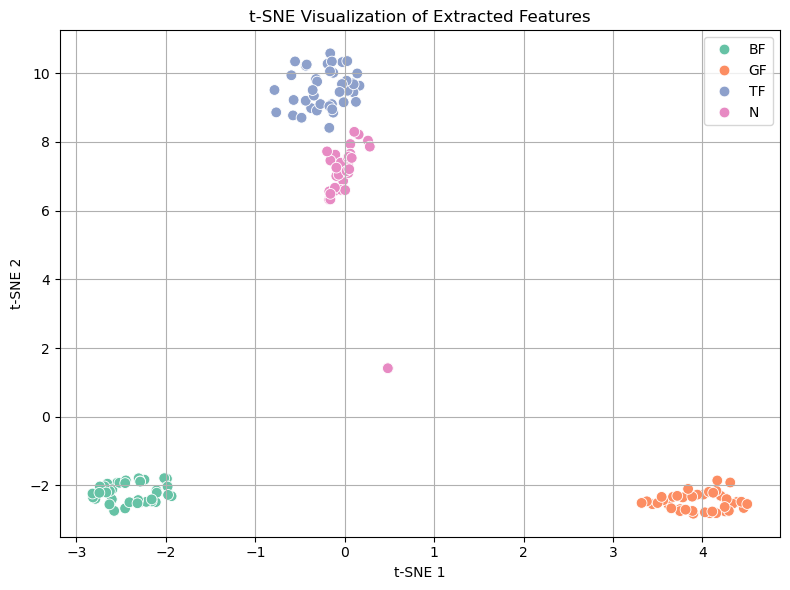


MLP Classifier Report:
              precision    recall  f1-score   support

          BF       1.00      1.00      1.00        10
          GF       1.00      1.00      1.00        10
           N       1.00      1.00      1.00        10
          TF       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



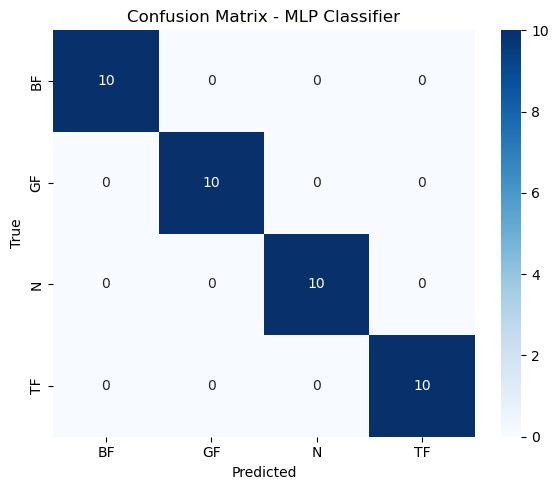

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

# Separate features and labels
X = df_features.drop('label', axis=1)
y = df_features['label']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- t-SNE visualization ---
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='Set2', s=60)
plt.title("t-SNE Visualization of Extracted Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Classifier Training (MLP as example) ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

# Try MLP first
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

# Evaluation
print("\nMLP Classifier Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=mlp.classes_, yticklabels=mlp.classes_)
plt.title("Confusion Matrix - MLP Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Top-level keys: ['#refs#', 'AE_ALL']
BF dataset shape: (1000000, 40)


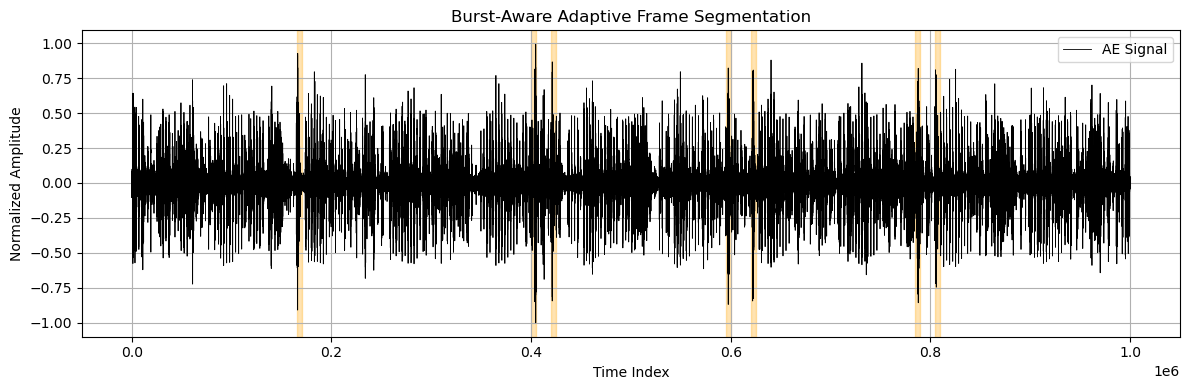

In [16]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Load .mat file using h5py ===
mat_path = r'E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\mat files data\AE_ALL.mat'
with h5py.File(mat_path, 'r') as f:
    # Keys available
    print("Top-level keys:", list(f.keys()))  # e.g., ['#refs#', 'AE_ALL']

    # Access 'AE_ALL' group and then 'BF' dataset
    bf_data = f['AE_ALL']['BF']  # This is a reference
    bf_ref = f[bf_data[0, 0]]  # Dereference

    # Check shape and contents
    print("BF dataset shape:", bf_ref.shape)  # Likely (1000000, 40)
    signal = np.array(bf_ref[:, 0])  # Use first channel

# === Step 2: Normalize signal ===
signal = signal - np.mean(signal)
signal = signal / np.max(np.abs(signal))

# === Step 3: Adaptive burst segmentation ===
window_size = 5000
beta = np.array([np.sum(signal[i:i+window_size]**2) 
                 for i in range(0, len(signal) - window_size, window_size)])
threshold = 0.6 * np.max(beta)
burst_indices = np.where(beta > threshold)[0]

# === Step 4: Plot signal and highlight burst segments ===
plt.figure(figsize=(12, 4))
plt.plot(signal, color='black', linewidth=0.6, label='AE Signal')
for idx in burst_indices:
    start = idx * window_size
    end = start + window_size
    plt.axvspan(start, end, color='orange', alpha=0.3)

plt.title('Burst-Aware Adaptive Frame Segmentation')
plt.xlabel('Time Index')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("burst_segmentation_ieee_style.png", dpi=300)
plt.show()
